<a href="https://colab.research.google.com/github/CameronLarsonFLT/PyTorch_FP_Prediction/blob/main/PyTorch_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting property: ex_max
Fetching https://www.fpbase.org/api/proteins/?parent_organism=6100&format=json …
Training neural network...


Training 0/10000 | 

EGFP predicted ex_max: 458.064


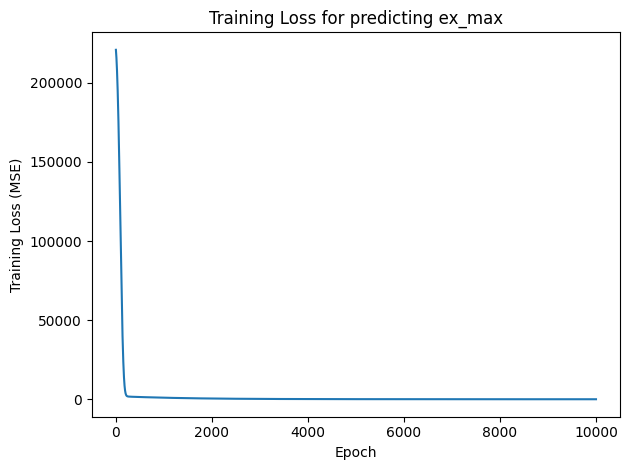

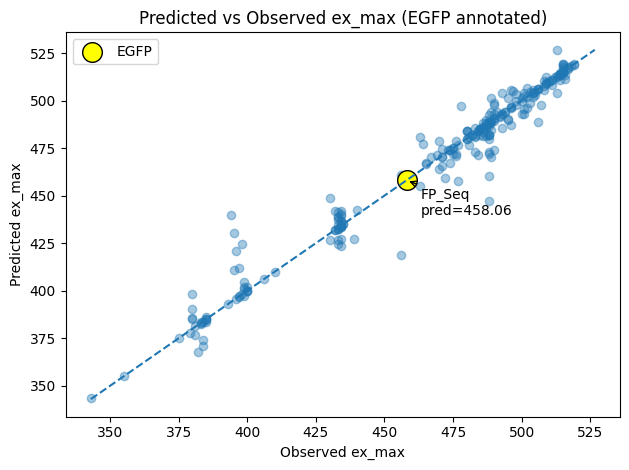

In [14]:
#@title Input Protein Sequence and Properties, then hit `Runtime` -> `Run all`

"""
Example script demonstrating how to retrieve fluorescent protein data from the
FPbase REST API and train a simple neural network using PyTorch to predict
various spectral or photophysical properties from the amino-acid sequence.
"""

import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import trange


#@markdown ---
#@markdown ## Property selection
#@markdown **Accepted values for `PROPERTY_NAME`:**
#@markdown
#@markdown - **Spectral**
#@markdown   - `ex_max` — excitation maximum *(nm)*
#@markdown   - `em_max` — emission maximum *(nm)*
#@markdown - **Photophysics**
#@markdown   - `brightness` — FPbase brightness
#@markdown   - `pka` — chromophore pKa
#@markdown ---

PROPERTY_NAME = 'ex_max' #@param {type:"string"}

#Define a Fluorescent Protein Sequence for Train-Test Validation
Fluorescent_Protein_Seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK' #@param {type:"string"}

#@markdown - **Commonly Used Taxonomy IDs**
#@markdown   - `6100`  *(Aequoria victoria)*
#@markdown   - `86600` *(Discosoma sp)*
#@markdown   - `6118`  *(Entacmaea quadricolor)*
#@markdown - **Leave Blank to Train on Full FPbase.org Sequence Data**
PARENT_ORGANISM = 6100  #@param {type:"integer"}

EXCLUDE_TERMS = ("channelrhodopsin", "rcamp", "gcamp2", "cp-mkate", "cegfp")
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"


# -----------------------------------------------------------------------------
def fetch_fpbase_proteins(parent_organism) -> list:
    """Retrieve proteins for a given parent organism from the FPbase API."""
    proteins: list = []

    # Normalize the FUNCTION ARGUMENT (not the global), so int/string/blank all work
    parent_organism = "" if parent_organism is None else str(parent_organism).strip()

    # Allow user to "leave blank" (and tolerate common null-ish strings)
    if parent_organism.lower() in ("", "none", "null"):
        parent_organism = ""

    if parent_organism:
        if not parent_organism.isdigit():
            raise ValueError(
                f"PARENT_ORGANISM must be numeric or blank. Got: {parent_organism!r}"
            )
        url = f"https://www.fpbase.org/api/proteins/?parent_organism={parent_organism}&format=json"
    else:
        print("TRAINING ON FULL FPBASE.ORG SEQUENCE DATA")
        url = "https://www.fpbase.org/api/proteins/?&format=json"

    while url:
        print(f"Fetching {url} …")
        resp = requests.get(url)
        resp.raise_for_status()
        data = resp.json()
        if isinstance(data, list):
            proteins.extend(data)
            break
        results = data.get("results", [])
        proteins.extend(results)
        url = data.get("next")
    return proteins


def compute_stokes_shift(protein: dict) -> float | None:
    for state in protein.get("states", []):
        ex = state.get("ex_max")
        em = state.get("em_max")
        if ex is not None and em is not None:
            return float(em) - float(ex)
    return None


def extract_property(protein: dict, property_name: str) -> float | None:
    if property_name == 'stokes_shift':
        return compute_stokes_shift(protein)
    states = protein.get("states", [])
    if states and isinstance(states, list):
        return states[0].get(property_name)
    return None


def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str = AMINO_ALPHABET) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    encoding = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            encoding[i, idx] = 1.0
    return encoding


class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# -----------------------------------------------------------------------------
def main() -> None:
    import sys
    global PROPERTY_NAME

    allowed_properties = {"stokes_shift", "ex_max", "em_max", "brightness", "pka"}
    for arg in sys.argv[1:]:
        if arg in allowed_properties:
            PROPERTY_NAME = arg
            break
    print(f"Predicting property: {PROPERTY_NAME}")

    proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)

    proteins = [
        p for p in proteins
        if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)
    ]

    samples: list[tuple[str, float]] = []
    for protein in proteins:
        seq = protein.get("seq")
        value = extract_property(protein, PROPERTY_NAME)
        if seq and value is not None:
            try:
                samples.append((seq, float(value)))
            except Exception:
                pass

    if not samples:
        raise RuntimeError(f"No valid samples retrieved for property '{PROPERTY_NAME}'.")

    max_len = max(len(seq) for seq, _ in samples)

    X = np.stack([one_hot_encode_sequence(seq, max_len, AMINO_ALPHABET) for seq, _ in samples])
    y = np.array([val for _, val in samples], dtype=np.float32)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    model = PropertyPredictor(input_len=max_len, alphabet_size=len(AMINO_ALPHABET))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    epochs = 10000
    print("Training neural network...")
    pbar = trange(
        epochs,
        desc="Training",
        unit="epoch",
        leave=True,
        colour='cyan',
        bar_format="{desc} {n_fmt}/{total_fmt} | {postfix}",
    )

    loss_history = []
    for _ in pbar:
        model.train()
        optimizer.zero_grad()
        preds = model(X_tensor)
        loss = criterion(preds, y_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        pbar.set_postfix_str(f"loss={loss.item():.3f}", refresh=True)

    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().cpu().numpy()

    # ---- EGFP prediction + annotation ----
    egfp_enc = one_hot_encode_sequence(Fluorescent_Protein_Seq, max_len, AMINO_ALPHABET)
    egfp_tensor = torch.tensor(egfp_enc, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        egfp_pred = float(model(egfp_tensor).squeeze().item())

    print(f"EGFP predicted {PROPERTY_NAME}: {egfp_pred:.3f}")

    plt.figure()
    plt.plot(range(1, epochs + 1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss (MSE)')
    plt.title(f'Training Loss for predicting {PROPERTY_NAME}')
    plt.tight_layout()
    plt.savefig(f'training_loss_{PROPERTY_NAME}.png')
    plt.show()

    plt.figure()
    plt.scatter(y, predictions, alpha=0.4)
    min_val = float(min(y.min(), predictions.min(), egfp_pred))
    max_val = float(max(y.max(), predictions.max(), egfp_pred))
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

    # Place EGFP on the diagonal for visibility (EGFP has no "observed" label here)
    plt.scatter([egfp_pred], [egfp_pred], s=200, marker='o', edgecolors='k',
                label='EGFP', color='yellow')
    plt.annotate(
        f"FP_Seq\npred={egfp_pred:.2f}",
        xy=(egfp_pred, egfp_pred),
        xytext=(10, -25),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->")
    )

    plt.xlabel(f'Observed {PROPERTY_NAME}')
    plt.ylabel(f'Predicted {PROPERTY_NAME}')
    plt.title(f'Predicted vs Observed {PROPERTY_NAME} (EGFP annotated)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'predicted_vs_observed_{PROPERTY_NAME}.png')
    plt.show()


if __name__ == '__main__':
    main()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PARENT_ORGANISM = 6100

# Exclude protein names containing any of these substrings
EXCLUDE_TERMS = ("channelrhodopsin", "rcamp", "gcamp2", "cp-mkate", "cegfp")

# Amino acid alphabet for one‑hot encoding
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"




# -----------------------------------------------------------------------------
def fetch_fpbase_proteins(parent_organism: int) -> list:
    """Retrieve proteins for a given parent organism from the FPbase API.

    Parameters
    ----------
    parent_organism : int
        Numeric identifier for the organism.  For example, 6100 corresponds
        to fluorescent proteins derived from Discosoma sp.

    Returns
    -------
    list of dict
        A list of protein objects as returned by the API.
    """
    proteins: list = []
    # url = f"https://www.fpbase.org/api/proteins/?parent_organism={parent_organism}&format=json"
    url = f"https://www.fpbase.org/api/proteins/?&format=json"

    while url:
        print(f"Fetching {url} …")
        resp = requests.get(url)
        resp.raise_for_status()
        data = resp.json()
        if isinstance(data, list):
            proteins.extend(data)
            break
        results = data.get("results", [])
        proteins.extend(results)
        url = data.get("next")
    return proteins

In [ ]:
def save_trained_bundle(
    path: str,
    model,
    *,
    max_len: int,
    amino_alphabet: str,
    property_name: str
):
    """
    Save everything needed to reload the model and run inference later without retraining.
    """
    bundle = {
        "state_dict": model.state_dict(),
        "max_len": int(max_len),
        "amino_alphabet": amino_alphabet,
        "property_name": property_name,
        "model_kwargs": {
            "input_len": int(max_len),
            "alphabet_size": int(len(amino_alphabet)),
        },
    }
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(bundle, path)

def load_trained_bundle(path: str, model_cls, device: str = "cpu"):
    """
    Load a saved model and return (model, bundle dict).
    """
    bundle = torch.load(path, map_location=device)
    model = model_cls(**bundle["model_kwargs"])
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model.to(device), bundle

In [ ]:
"""
This script trains fluorescent protein property prediction models for one or more properties.

It mirrors the existing `main()` training loop that trains a single-property model but
allows the caller to specify multiple properties to train sequentially. For each property,
the script will:

  * Fetch and filter FPbase sequences using `fetch_fpbase_proteins` and `EXCLUDE_TERMS`.
  * Build one-hot encoded input tensors based on `AMINO_ALPHABET`.
  * Train an instance of `PropertyPredictor` on the selected property using mean squared
    error as the loss function.
  * Save the trained model bundle to disk via `save_trained_bundle`.
  * Optionally plot the training loss history.

Assumptions:
  - Functions `fetch_fpbase_proteins`, `extract_property`, `one_hot_encode_sequence`,
    the `PropertyPredictor` class, and constants `PARENT_ORGANISM`, `EXCLUDE_TERMS`,
    `AMINO_ALPHABET` exist in the environment that imports this module.
  - Functions `save_trained_bundle` and `load_trained_bundle` are also available in
    the environment. These are used to save and reload trained model bundles.

Example usage:

    from train_fp_properties import train_fp_properties

    # train brightness and pKa models, forcing retrain and using GPU if available
    results = train_fp_properties(
        property_names=["brightness", "pka"],
        input_seq=my_sequence,
        epochs=3000,
        force_retrain=True,
        model_dir="models",
        device="cuda" if torch.cuda.is_available() else "cpu",
        make_plots=True,
    )

"""

from typing import Iterable, Dict, Tuple, List
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import trange

# Ensure required helpers and constants exist in the importing namespace. If any of
# these are missing, a NameError will be raised when this module is imported. The
# caller should define or import these before importing this module.
try:
    fetch_fpbase_proteins  # type: ignore[name-defined]
    extract_property  # type: ignore[name-defined]
    one_hot_encode_sequence  # type: ignore[name-defined]
    PropertyPredictor  # type: ignore[name-defined]
    PARENT_ORGANISM  # type: ignore[name-defined]
    EXCLUDE_TERMS  # type: ignore[name-defined]
    AMINO_ALPHABET  # type: ignore[name-defined]
    save_trained_bundle  # type: ignore[name-defined]
    load_trained_bundle  # type: ignore[name-defined]
except NameError as e:
    raise ImportError(
        "Required helper functions or constants are not defined in the importing namespace: "
        f"{e}"
    )

from pathlib import Path
import torch





def _predict_sequence_local(
    model: torch.nn.Module,
    seq: str,
    max_len: int,
    alphabet: str,
    device: str,
) -> float:
    """
    Local helper to predict a scalar property for a single sequence using the trained model.
    This function does not rely on any external helper and uses the local encoding.

    Args:
        model: Trained PyTorch model that accepts (batch, L, A) inputs and outputs (batch, 1).
        seq: Amino acid sequence to encode.
        max_len: Maximum length used for training (for padding/truncation).
        alphabet: String representing the alphabet order used during training.
        device: Device string (e.g. "cpu" or "cuda") where the model resides.

    Returns:
        A single float prediction for the provided sequence.
    """
    enc = one_hot_encode_sequence(seq, max_len, alphabet)  # type: ignore[name-defined]
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        return float(model(x).squeeze().item())


def _train_single_property(
    property_name: str,
    *,
    input_seq: str,
    epochs: int,
    force_retrain: bool,
    model_dir: str,
    device: str,
    make_plots: bool,
) -> Tuple[
    torch.nn.Module,
    int,
    torch.Tensor,
    torch.Tensor,
    np.ndarray,
    float,
]:
    """
    Train or load a model for a single FP property.

    Args:
        property_name: Property to train on (e.g. "brightness", "pka").
        input_seq: Sequence used for immediate prediction after training.
        epochs: Number of training epochs.
        force_retrain: If True, ignore any saved model and retrain from scratch.
        model_dir: Directory where the model bundle is saved/loaded.
        device: Target device for training ("cpu" or "cuda").
        make_plots: If True, plot the training loss history.

    Returns:
        A tuple containing:
          - The trained model
          - The maximum sequence length used for encoding
          - The tensor of one-hot encoded training sequences
          - The tensor of training labels
          - A numpy array of model predictions on the training set
          - The model's prediction for the provided input_seq
    """
    # Ensure model directory exists
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"fp_{property_name}.pt")

    # If a saved model exists and retrain is not forced, load and return predictions
    if not force_retrain and os.path.exists(model_path):
        model, bundle = load_trained_bundle(model_path, PropertyPredictor, device=device)  # type: ignore[name-defined]
        max_len = int(bundle["max_len"])
        amino_alphabet = bundle["amino_alphabet"]

        input_pred = _predict_sequence_local(model, input_seq, max_len, amino_alphabet, device)

        # Rebuild training data for evaluation and plotting
        proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)  # type: ignore[name-defined]
        proteins = [
            p
            for p in proteins
            if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)  # type: ignore[name-defined]
        ]
        samples: List[Tuple[str, float]] = []
        for protein in proteins:
            seq = protein.get("seq")
            val = extract_property(protein, property_name)  # type: ignore[name-defined]
            if seq and val is not None:
                try:
                    samples.append((seq, float(val)))
                except Exception:
                    pass
        if not samples:
            raise RuntimeError(
                f"No valid samples retrieved for property '{property_name}' when loading model."
            )
        X = np.stack([
            one_hot_encode_sequence(seq, max_len, amino_alphabet)  # type: ignore[name-defined]
            for seq, _ in samples
        ])
        y = np.array([val for _, val in samples], dtype=np.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).squeeze().detach().cpu().numpy()
        return model, max_len, X_tensor, y_tensor, preds, input_pred

    # Otherwise train from scratch
    proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)  # type: ignore[name-defined]
    proteins = [
        p
        for p in proteins
        if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)  # type: ignore[name-defined]
    ]
    samples: List[Tuple[str, float]] = []
    for protein in proteins:
        seq = protein.get("seq")
        val = extract_property(protein, property_name)  # type: ignore[name-defined]
        if seq and val is not None:
            try:
                samples.append((seq, float(val)))
            except Exception:
                pass
    if not samples:
        raise RuntimeError(f"No valid samples retrieved for property '{property_name}'.")

    max_len = max(len(seq) for seq, _ in samples)
    X = np.stack(
        [one_hot_encode_sequence(seq, max_len, AMINO_ALPHABET)  # type: ignore[name-defined]
         for seq, _ in samples]
    )
    y = np.array([val for _, val in samples], dtype=np.float32)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

    model = PropertyPredictor(
        input_len=max_len,
        alphabet_size=len(AMINO_ALPHABET),
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    pbar = trange(
        epochs,
        desc=f"Training {property_name}",
        unit="epoch",
        leave=True,
        colour="cyan",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [ETA {remaining}] {postfix}",
    )
    loss_history: List[float] = []
    for _ in pbar:
        model.train()
        optimizer.zero_grad()
        preds = model(X_tensor)
        loss = criterion(preds, y_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        pbar.set_postfix_str(f"loss={loss.item():.3f}", refresh=True)

    # Save the trained model bundle for future use
    save_trained_bundle(
        model_path,
        model,
        max_len=max_len,
        amino_alphabet=AMINO_ALPHABET,  # type: ignore[name-defined]
        property_name=property_name,
    )

    # Evaluate on the full training set for later analysis
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().detach().cpu().numpy()

    # Predict the property for the provided sequence
    input_pred = _predict_sequence_local(
        model,
        input_seq,
        max_len,
        AMINO_ALPHABET,  # type: ignore[name-defined]
        device,
    )

    # Optionally plot training loss
    if make_plots:
        plt.figure(figsize=(7, 4))
        plt.plot(range(1, epochs + 1), loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss (MSE)")
        plt.title(f"Training Loss for {property_name}")
        plt.tight_layout()
        plt.show()

    return model, max_len, X_tensor, y_tensor, predictions, input_pred


def train_fp_properties(
    property_names: Iterable[str],
    *,
    input_seq: str,
    epochs: int = 5000,
    force_retrain: bool = False,
    model_dir: str = "models",
    device: str = "cpu",
    make_plots: bool = False,
) -> Dict[str, Tuple[torch.nn.Module, int, torch.Tensor, torch.Tensor, np.ndarray, float]]:
    """
    Train (or load) models for a list of fluorescent protein properties.

    This function is a convenience wrapper that iterates over `property_names`, calling
    the single-property training routine for each. It returns a dictionary of results.

    Args:
        property_names: Iterable of property names to train (e.g., ["brightness", "pka"]).
        input_seq: Amino acid sequence to evaluate immediately after training each model.
        epochs: Number of epochs to train each model. Default is 5000.
        force_retrain: If True, ignore existing saved models and retrain from scratch for
            each property.
        model_dir: Directory where model bundles will be saved and loaded from.
        device: Device string ("cpu" or "cuda"). If "cuda" is specified but not
            available, training will fall back to CPU silently.
        make_plots: Whether to produce a training loss plot for each property.

    Returns:
        A dictionary keyed by property name. Each value is the tuple returned by
        `_train_single_property` containing: (model, max_len, X_tensor, y_tensor,
        predictions_on_training_set, input_prediction).

    Notes:
        If you specify a large list of properties and large numbers of epochs, the
        training may take significant time. Consider lowering `epochs` or disabling
        plots for quicker experimentation.
    """
    results: Dict[str, Tuple[
        torch.nn.Module,
        int,
        torch.Tensor,
        torch.Tensor,
        np.ndarray,
        float,
    ]] = {}
    # Normalize device selection: if CUDA is requested but unavailable, use CPU
    device = device if (device == "cuda" and torch.cuda.is_available()) else "cpu"
    for prop in property_names:
        print(f"=== Training model for property: {prop} ===")
        results[prop] = _train_single_property(
            prop,
            input_seq=input_seq,
            epochs=epochs,
            force_retrain=force_retrain,
            model_dir=model_dir,
            device=device,
            make_plots=make_plots,
        )
        print(f"=== Completed training for property: {prop}\n")
    return results

In [ ]:
property_names = ["brightness", "ex_max", "em_max", 'pka']  # <-- set here
results = train_fp_properties(
    property_names=property_names,
    input_seq=Fluorescent_Protein_Seq,
    force_retrain=True,
    model_dir="/content/drive/MyDrive/PyTorch/PyTorch_Training_Data",
    epochs=200,
    device="cuda",
    make_plots=False
)

In [ ]:
import os
import re
import pandas as pd
import torch
import numpy as np

# ------------- CONFIGURATION -------------
OUTPUT_PATH = '/content/drive/MyDrive/PyTorch/PyTorch_Output_Data'
FASTA_PATH = "/content/drive/MyDrive/Machine_Learning_FP_Evolution/EGFP_Ex_Max_Reverse_Evolved_Sequences_From_ML.fasta"
MODEL_DIR = "/content/drive/MyDrive/PyTorch/PyTorch_Training_Data"
PROPERTY_NAMES = ["brightness", "pka", "ex_max", "em_max",]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ---------- REQUIRED DEFINITIONS ----------
# Ensure these exist in your notebook runtime:
# - PropertyPredictor class (same architecture used during training)
# - one_hot_encode_sequence(seq, max_len, alphabet)
# If they are not in scope, import them or paste their definitions here.

def load_trained_bundle(path: str, model_cls, device: str = "cpu"):
    """
    Load a saved model and return (model, bundle dict).
    """
    bundle = torch.load(path, map_location=device)
    model = model_cls(**bundle["model_kwargs"])
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model.to(device), bundle

def read_fasta(path: str):
    """
    Returns a list of dicts: {"id":..., "desc":..., "seq":...} for each record.
    """
    records = []
    with open(path, "r") as f:
        seq_id, desc, buf = None, "", []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if seq_id is not None:
                    records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
                header = line[1:]
                parts = header.split(None, 1)
                seq_id = parts[0]
                desc = parts[1] if len(parts) > 1 else ""
                buf = []
            else:
                buf.append(line)
        if seq_id is not None:
            records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
    return records

def sanitize_seq(seq: str):
    """Remove whitespace and uppercase a sequence."""
    return re.sub(r"\s+", "", (seq or "").upper())

def predict_property(model, seq: str, *, max_len: int, alphabet: str):
    """
    Encode a sequence and produce a scalar prediction.
    """
    enc = one_hot_encode_sequence(seq, max_len, alphabet)  # (max_len, alphabet_size)
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        return float(model(x).squeeze().item())

# ---------- LOAD ALL MODELS ----------
# Each property gets its own model and encoding parameters.
models_info = {}
for prop in PROPERTY_NAMES:
    path = os.path.join(MODEL_DIR, f"fp_{prop}.pt")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found for {prop}: {path}")
    model, bundle = load_trained_bundle(path, PropertyPredictor, device=DEVICE)
    models_info[prop] = {
        "model": model,
        "max_len": int(bundle["max_len"]),
        "alphabet": bundle["amino_alphabet"],
    }
    print(f"Loaded {prop} model with max_len={models_info[prop]['max_len']}")

# ---------- READ FASTA ----------
records = read_fasta(FASTA_PATH)
if not records:
    raise RuntimeError(f"No FASTA records found in {FASTA_PATH}")
print("Number of sequences:", len(records))

# ---------- PREDICT FOR ALL PROPERTIES ----------
rows = []
for rec in records:
    seq_raw = sanitize_seq(rec["seq"])
    row = {
        "id": rec["id"],
        "desc": rec["desc"],
        "seq_len": len(seq_raw),
        "sequence": seq_raw,
    }
    # Track unknown/truncated characters per model (optional)
    for prop in PROPERTY_NAMES:
        info = models_info[prop]
        alphabet_set = set(info["alphabet"])
        max_len = info["max_len"]
        row[f"unknown_{prop}"] = sum(1 for ch in seq_raw if ch not in alphabet_set)
        row[f"trunc_{prop}"] = max(0, len(seq_raw) - max_len)
        pred = predict_property(
            info["model"],
            seq_raw,
            max_len=max_len,
            alphabet=info["alphabet"],
        )
        row[f"pred_{prop}"] = pred
    rows.append(row)

# ---------- BUILD DATAFRAME ----------
df = pd.DataFrame(rows)

# Example: sort by brightness descending
df_sorted = df.sort_values(by="pred_brightness", ascending=False).reset_index(drop=True)

# print(df_sorted.head(10)[["id", "seq_len"] + [f"pred_{p}" for p in PROPERTY_NAMES]])
# Save to CSV if desired
fasta_base = os.path.splitext(os.path.basename(FASTA_PATH))[0]

out_csv = os.path.join(OUTPUT_PATH,fasta_base + "_ANN_predictions_multi_parameters.csv")
df_sorted.to_csv(out_csv, index=False)
print("Saved predictions:", out_csv)


In [ ]:
import os
import re
import pandas as pd
import torch
import numpy as np

# ------------- CONFIGURATION -------------
OUTPUT_PATH = '/content/drive/MyDrive/PyTorch/PyTorch_Output_Data'
FASTA_DIR = "/content/drive/MyDrive/Machine_Learning_FP_Evolution"
MODEL_DIR = "/content/drive/MyDrive/PyTorch/PyTorch_Training_Data"
PROPERTY_NAMES = ["brightness", "pka", "ex_max", "em_max",]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Collect all fasta-like files in the directory
fasta_files = [
    os.path.join(FASTA_DIR, f)
    for f in os.listdir(FASTA_DIR)
    if f.lower().endswith((".fasta", ".fa", ".faa"))
]
print("Found FASTA files:", len(fasta_files))

# ---------- REQUIRED DEFINITIONS ----------
# Ensure these exist in your notebook runtime:
# - PropertyPredictor class (same architecture used during training)
# - one_hot_encode_sequence(seq, max_len, alphabet)

def load_trained_bundle(path: str, model_cls, device: str = "cpu"):
    """
    Load a saved model and return (model, bundle dict).
    """
    bundle = torch.load(path, map_location=device)
    model = model_cls(**bundle["model_kwargs"])
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model.to(device), bundle

def read_fasta(path: str):
    """
    Returns a list of dicts: {"id":..., "desc":..., "seq":...} for each record.
    """
    records = []
    with open(path, "r") as f:
        seq_id, desc, buf = None, "", []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if seq_id is not None:
                    records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
                header = line[1:]
                parts = header.split(None, 1)
                seq_id = parts[0]
                desc = parts[1] if len(parts) > 1 else ""
                buf = []
            else:
                buf.append(line)
        if seq_id is not None:
            records.append({"id": seq_id, "desc": desc, "seq": "".join(buf)})
    return records

def sanitize_seq(seq: str):
    """Remove whitespace and uppercase a sequence."""
    return re.sub(r"\s+", "", (seq or "").upper())

def predict_property(model, seq: str, *, max_len: int, alphabet: str):
    """
    Encode a sequence and produce a scalar prediction.
    """
    enc = one_hot_encode_sequence(seq, max_len, alphabet)  # (max_len, alphabet_size)
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        return float(model(x).squeeze().item())

# ---------- LOAD ALL MODELS ----------
# Each property gets its own model and encoding parameters.
models_info = {}
for prop in PROPERTY_NAMES:
    path = os.path.join(MODEL_DIR, f"fp_{prop}.pt")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found for {prop}: {path}")
    model, bundle = load_trained_bundle(path, PropertyPredictor, device=DEVICE)
    models_info[prop] = {
        "model": model,
        "max_len": int(bundle["max_len"]),
        "alphabet": bundle["amino_alphabet"],
    }
    print(f"Loaded {prop} model with max_len={models_info[prop]['max_len']}")

# ---------- LOOP OVER ALL FASTA FILES ----------
for FASTA_PATH in sorted(fasta_files):

    # ---------- READ FASTA ----------
    records = read_fasta(FASTA_PATH)
    if not records:
        print(f"Skipping empty FASTA: {FASTA_PATH}")
        continue
    print("\nScoring:", FASTA_PATH)
    print("Number of sequences:", len(records))

    # ---------- PREDICT FOR ALL PROPERTIES ----------
    rows = []
    for rec in records:
        seq_raw = sanitize_seq(rec["seq"])
        row = {
            "id": rec["id"],
            "desc": rec["desc"],
            "seq_len": len(seq_raw),
            "sequence": seq_raw,
        }
        # Track unknown/truncated characters per model (optional)
        for prop in PROPERTY_NAMES:
            info = models_info[prop]
            alphabet_set = set(info["alphabet"])
            max_len = info["max_len"]
            row[f"unknown_{prop}"] = sum(1 for ch in seq_raw if ch not in alphabet_set)
            row[f"trunc_{prop}"] = max(0, len(seq_raw) - max_len)
            pred = predict_property(
                info["model"],
                seq_raw,
                max_len=max_len,
                alphabet=info["alphabet"],
            )
            row[f"pred_{prop}"] = pred
        rows.append(row)

    # ---------- BUILD DATAFRAME ----------
    df = pd.DataFrame(rows)

    # Example: sort by brightness descending
    df_sorted = df.sort_values(by="pred_brightness", ascending=False).reset_index(drop=True)

    # ---------- SAVE TO CSV ----------
    fasta_base = os.path.splitext(os.path.basename(FASTA_PATH))[0]
    out_csv = os.path.join(OUTPUT_PATH, fasta_base + "_ANN_predictions_multi_parameters.csv")
    df_sorted.to_csv(out_csv, index=False)
    print("Saved predictions:", out_csv)
